# R-CNN 구현
## Step1. Selective Search로 약 2000개의 region proposal 생성
## Step2. 각 region proposal을 CNN에 입력해 classification 수행 
- 논문과는 조금 다른 점이 있다  
- 논문에서는 region proposal들을 crop 및 resize를 한 후 CNN을 통해 feature vector를 추출한 후  
- Linear SVM을 통해 classification을 수행하지만  
- 여기에선 CNN으로 classification까지 수행하도록 코드를 짰다.

In [13]:
import os
import time
import random
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

# package and module
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# image와 annotation 데이터 로드
def get_data(path):
    img_files = glob.glob(path+'/*.jpg')[:30]
    ano_files = glob.glob(path+'/*.xml')[:30]
    img_list, ano_list = [], []
    for img in img_files:
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_list.append(img)
    for ano in ano_files:
        ano = ET.parse(ano).getroot()
        obj = ano.findall('object')
        bbox_list = []
        for i in range(len(obj)):
            bbox_list.append([
                int(obj[i].find('bndbox').find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')
            ])
        ano_list.append(bbox_list)
    return img_list, ano_list

path = './fruits/train'
train_image, train_anno = get_data(path)

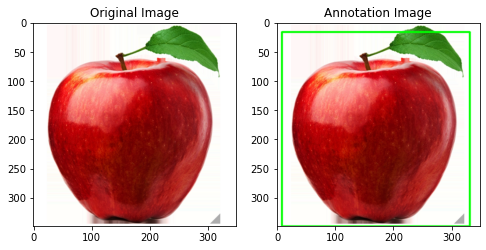

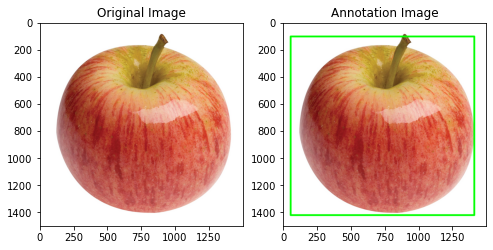

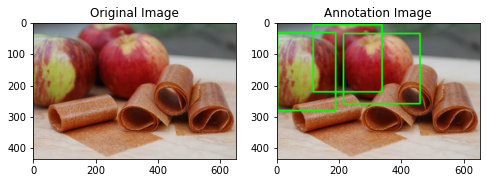

In [5]:
# 원본 이미지와 ground truth box 보여주기 
def show_sample(ncols, images, bboxes):
    for i in range(ncols):
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(images[i])
#         ax[0].axis('off')
        ax[0].set_title('Original Image')
        img_copy = images[i].copy()
        for j in range(len(bboxes[i])):
            x1, y1, x2, y2 = bboxes[i][j]
            cv2.rectangle(img_copy, (x1, y1), (x2, y2),
                          (0,255,0), int(img_copy.shape[0]*0.008), cv2.LINE_AA)
        ax[1].imshow(img_copy)
#         ax[1].axis('off')
        ax[1].set_title('Annotation Image')
        fig.show()
        
show_sample(3, train_image, train_anno)

In [6]:
# selective search 수행하는 함수 정의
def selective_search(image):
    # 카피본 생성
    img_copy = image.copy()
    # selective search 생성
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img_copy)
    ss.switchToSelectiveSearchFast()
    ss_result = ss.process()
    return ss_result

In [7]:
# IoU 계산하는 함수 정의
def get_iou(bb1, bb2):
    if bb1[0]<bb1[2] and bb1[1]<bb1[3] and bb2[0]<bb2[2] and bb2[1]<bb2[3]:
        
        x_left = max(bb1[0], bb2[0])
        y_top = max(bb1[1], bb2[1])
        x_right = min(bb1[2], bb2[2])
        y_bottom = min(bb1[3], bb2[3])
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right-x_left)*(y_bottom-y_top)
        bb1_area = (bb1[2]-bb1[0])*(bb1[3]-bb1[1])
        bb2_area = (bb2[2]-bb2[0])*(bb2[3]-bb2[1])
        iou = intersection_area/float(bb1_area+bb2_area-intersection_area)
        assert iou >= 0.0
        assert iou <= 1.0
        return iou
    else:
        return 0.0

In [8]:
# selective search를 수행한 후 bounding box를 잘라내 resize하는 코드
train_images, train_labels = [], []

for i, image in tqdm(enumerate(train_image)):
    bbox = train_anno[i]
    for box in bbox:
        # selective search 수행
        ss_results = selective_search(image)
        s = 0
        for ss in ss_results:
            x1, y1, x2, y2 = ss
            # IoU 얻기
            iou = get_iou(box, ss)
            if s<500:
                if iou > 0.7:
                    img_crop = image[y1:y1+y2, x1:x1+x2]
                    resized = cv2.resize(img_crop, (224,224), cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(1)
                else:
                    img_crop = image[y1:y1+y2, x1:x1+x2]
                    resized = cv2.resize(img_crop, (224,224), cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
            s += 1

0it [00:00, ?it/s]

In [11]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

In [16]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

for layer in vgg.layers[:-2]:
    layer.trainable = False
    
x = vgg.get_layer('fc2')
last_output = x.output
x = tf.keras.layers.Dense(1, activation='sigmoid')(last_output)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model = tf.keras.Model(vgg.input, x)
model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
EPOCH = 50
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=EPOCH, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[es],
                    shuffle=True)

Epoch 1/50
278/278 [==============================] - 31s 93ms/step - loss: 0.2352 - accuracy: 0.9934 - val_loss: 0.1562 - val_accuracy: 0.9919- 
Epoch 2/50
278/278 [==============================] - 22s 80ms/step - loss: 0.0202 - accuracy: 0.9973 - val_loss: 0.0814 - val_accuracy: 0.9919
Epoch 3/50
278/278 [==============================] - 23s 83ms/step - loss: 0.0084 - accuracy: 0.9979 - val_loss: 0.1198 - val_accuracy: 0.9921
Epoch 4/50
278/278 [==============================] - 23s 81ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 0.0552 - val_accuracy: 0.9912
Epoch 5/50
278/278 [==============================] - 22s 78ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.1402 - val_accuracy: 0.9921
Epoch 6/50
278/278 [==============================] - 22s 79ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0865 - val_accuracy: 0.9921
Epoch 7/50
278/278 [==============================] - 22s 79ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.1305 - val_accurac

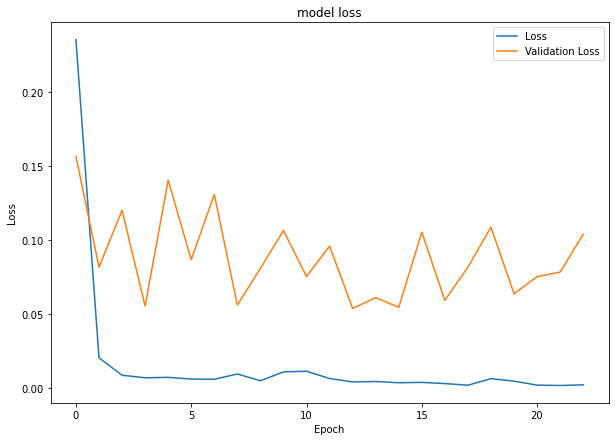

In [18]:
# plt.plot(history.history["acc"])
# plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [19]:
path = './fruits/test'
test_image, test_anno = get_data(path)

In [34]:
def r_cnn_test(test_images):
    test_result = []
    for i in tqdm(range(len(test_images))):
        image = test_images[i]
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        
        imOut = image.copy()
        boxes = []
        count = 0
        for e,result in enumerate(ssresults):
            if e < 1000:
                x1, y1, x2, y2 = result
                timage = imOut[y1:y1+y2, x1:x1+x2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                resized = np.expand_dims(resized, axis=0)
                out = model.predict(resized)
#                 print(e,out)
        #     if out[0][0]<out[0][1]:
                boxes.append([x1,y1,x2,y2])
                count+=1
        
        for box in boxes:
            x, y, w, h = box
#             print(x,y,w,h)
        #     imOut = imOut[x:x+w,y:y+h]
            cv2.rectangle(imOut, (x1, y1), (x1+x2, y1+y2), (0, 255, 0), 1, cv2.LINE_AA)
        # plt.figure()
        test_result.append(imOut)
    return test_result

In [35]:
test_predicted = r_cnn_test(test_image)

  0%|          | 0/30 [00:00<?, ?it/s]

In [44]:
def compare_image(test_true_image, test_true_anno, test_predict):
    for i in range(len(test_true_image)):
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(test_predict[i])
        ax[0].axis('off')
        ax[0].set_title('Predicted Box')
        
        img_copy = test_true_image[i].copy()
        for j in range(len(test_true_anno[i])):
            x1, y1, x2, y2 = test_true_anno[i][j]
            cv2.rectangle(img_copy, (x1, y1), (x2, y2),
                          (0,255,0), int(img_copy.shape[0]*0.008), cv2.LINE_AA)
            ax[1].imshow(img_copy)
            ax[1].axis('off')
            ax[1].set_title('Ground Truth Box')
            fig.show()

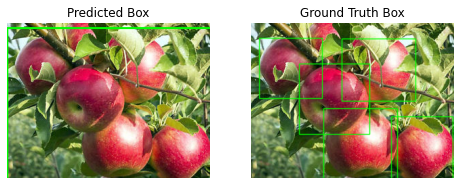

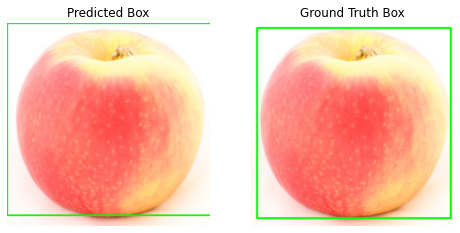

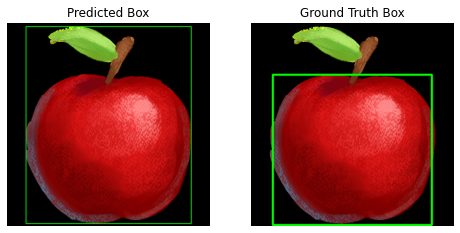

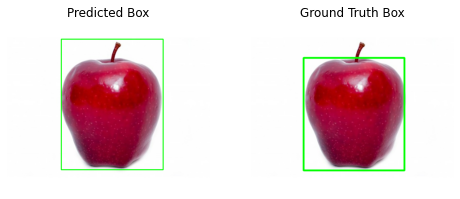

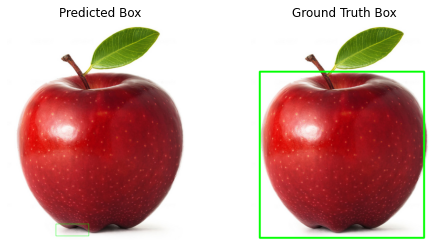

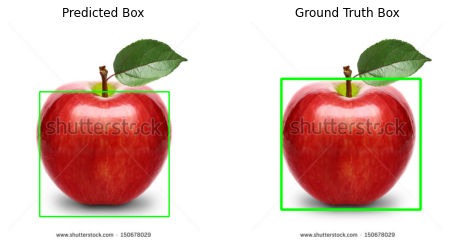

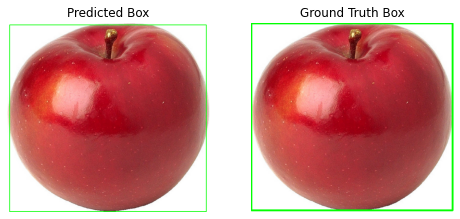

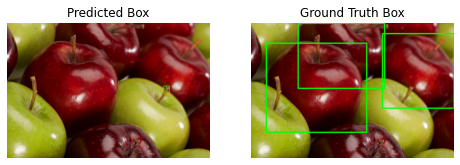

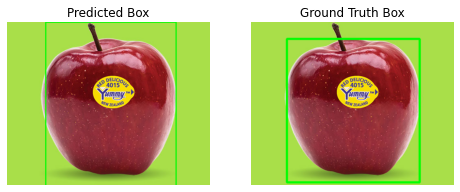

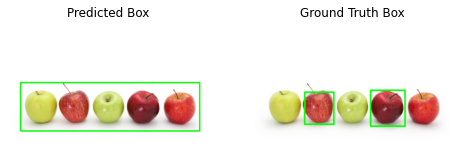

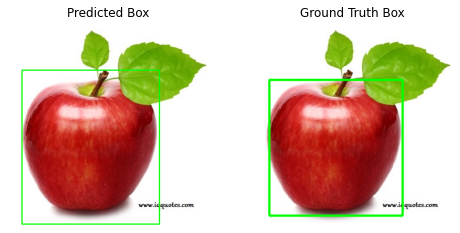

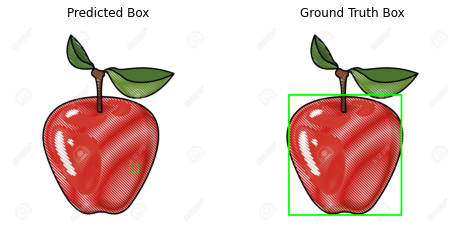

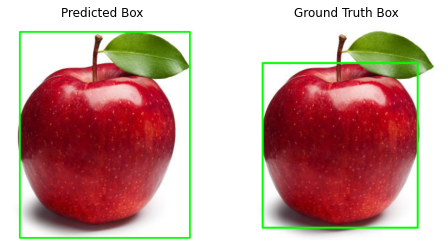

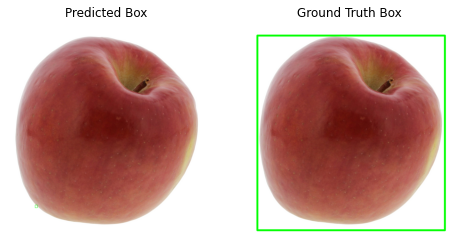

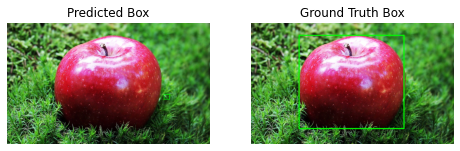

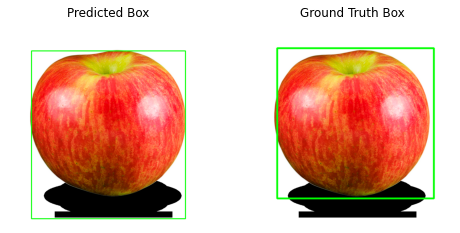

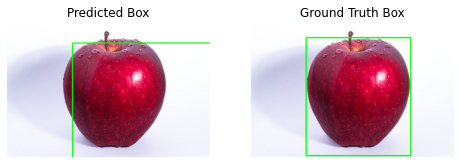

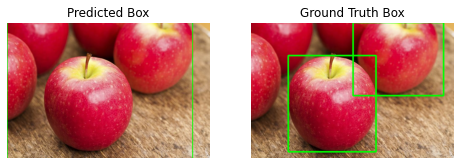

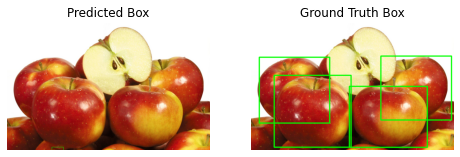

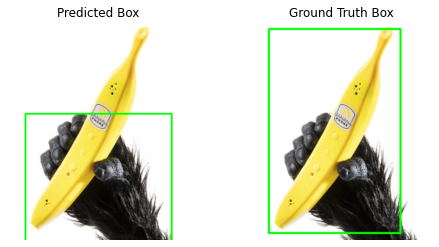

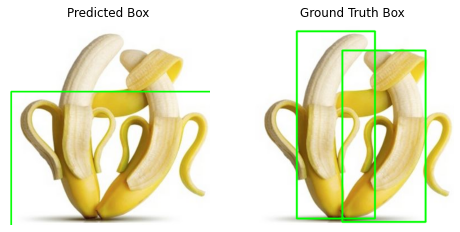

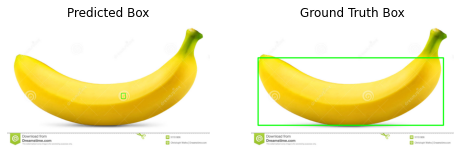

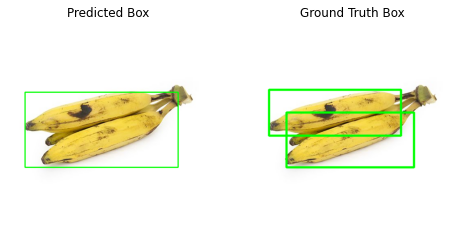

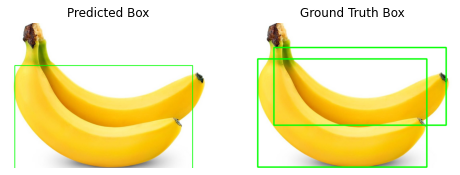

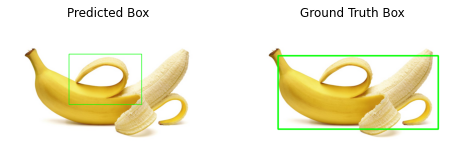

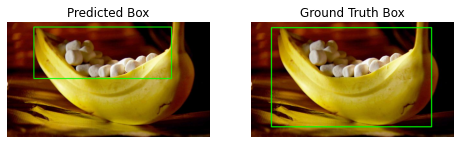

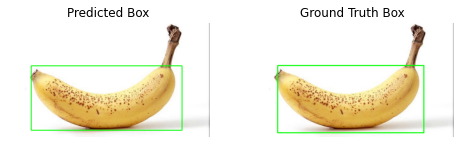

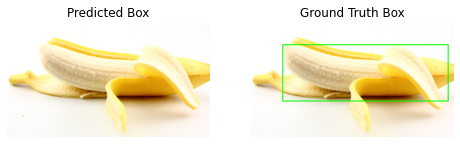

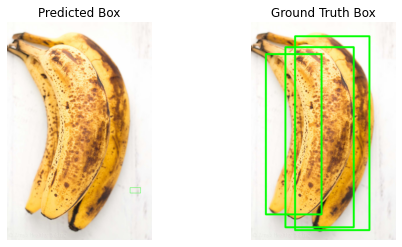

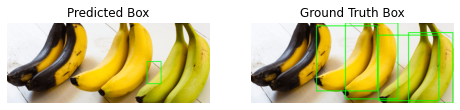

In [45]:
compare_image(test_image, test_anno, test_predicted)

In [43]:
test_anno[0][4]

[207, 138, 298, 229]

In [46]:
19940+10400

30340